# Selecting data based on spatial relationships

In this new notebook about learning GIS, we will dive into data selection based on spatial relationships. When working with geospatial data, you often need to do specific GIS operations based on how the data layers are located in relation to each other. For instance, finding out if a certain point is located inside an area, or whether a line intersects with another line or a polygon, are very common operations for selecting data based on spatial location.

These kind of queries are commonly called as **spatial queries**. Spatial queries are conducted based on the topological spatial relations which are fundamental constructs that describe how two or more geometric objects relate to each other concerning their position and boundaries. Topological spatial relations can be exemplified by relationships such as contains, touches and intersects. In GIS, the topological relations play a crucial role as they enable queries that are less concerned with the exact coordinates or shapes of geographic entities but more focused on their relative arrangements and positions. 

#### Making spatial queries in Python

Spatial queries using Python are implemented in **shapely** and **geopandas**, including:
- .intersects()
- .within()
- .contains()
- .overlaps()
- .touches()
- .covers()
- .covered_by()
- .equals()
- .disjoint()
- .crosses()

To use Python to find out how two geometric objects are related to each other topologically, you start by creating the geometries using **shapely** library. 

In the following, we create a couple of Point objects and one Polygon object which we can use to test how they relate to each other:

In [22]:
# Import libraries
from shapely import Point, Polygon

# Create point objects
point1 = Point(24.952242, 60.1696017)
point2 = Point(24.976567, 60.1612500)

# Create a Polygon
coordinates = [
    (24.950899, 60.169158),
    (24.953492, 60.169158),
    (24.953510, 60.170104),
    (24.950958, 60.169990)
]

polygon = Polygon(coordinates)


In [23]:
# Check the created geometries
print(point1)
print(point2)
print(polygon)


POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


Considering the coordinates, we can test whether the Point geometries stored in point1 and point2 are within the polygon, by calling the *.within()* method as follows:

In [24]:
# Is point 1 within the polygon?
point1.within(polygon)

True

In [25]:
# Is point 2 within the polygon?
point2.within(polygon)

False

So, point1 is within the polygon, but point2 is not.


One of the most common spatial queries is to see if a geometry intersects or touches another one. Again, there are binary operations in shapely for checking these spatial relationships:

- *.intersects()* - Two objects intersect if the boundary or interior of one object intersect in any way with the boundary or interior of the other object.

- *.touches()* - Two objects touch if the objects have at least one point in common and their interiors do not intersect with any part of the other object.

Let’s try these by creating two LineString geometries and test whether they intersect and touch each other:

In [26]:
# Import needed modules
from shapely import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

In [27]:
# Do they intersect?
line_a.intersects(line_b)

True

In [28]:
# Do they touch?
line_a.touches(line_b)

True

Both lines touch and intersect. We can plot them to check it again:

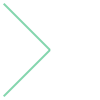

In [29]:
# Create a multilinestring from both lines
multi_line = MultiLineString([line_a, line_b])
multi_line

#### Spatial queries using geopandas

Conducting spatial queries with geopandas is handy because you can easily compare the spatial relationships between multiple geometries stored in separate GeoDataFrames.

In the following examplewe can check which points are located within specific areas of Helsinki. Let’s start by reading data that contains Polygons for major districts in Helsinki Region, as well as a few point observations that represent addresses around Helsinki that we geocoded in the previous section:

In [30]:
# Importing Geopandas
import geopandas as gpd

# Read the files
points = gpd.read_file("data/Helsinki/addresses.shp")
districts = gpd.read_file("data/Helsinki/Major_districts.gpkg")

In [31]:
# Print the points data
print("Shape: ", points.shape)
print(points.head())

Shape:  (34, 1)
                    geometry
0   POINT (24.91556 60.1632)
1  POINT (24.93166 60.16905)
2  POINT (24.94168 60.16996)
3  POINT (24.97865 60.19005)
4  POINT (24.92151 60.15662)


In [32]:
# Print the districts data
print("Shape: ", districts.shape)
print(districts.head())

Shape:  (23, 3)
               Name Description  \
0  Suur-Espoonlahti               
1    Suur-Kauklahti               
2       Vanha-Espoo               
3     Pohjois-Espoo               
4    Suur-Matinkylä               

                                            geometry  
0  POLYGON Z ((24.77506 60.10906 0, 24.7766 60.10...  
1  POLYGON Z ((24.61578 60.17257 0, 24.61558 60.1...  
2  POLYGON Z ((24.67576 60.21201 0, 24.67524 60.2...  
3  POLYGON Z ((24.76792 60.2692 0, 24.76996 60.26...  
4  POLYGON Z ((24.75361 60.16631 0, 24.75376 60.1...  


Let's try to find all points that are within two areas in Helsinki region, namely Itäinen and Eteläinen. Let’s first select the districts using the **.loc** indexer and the listed criteria which we can use with the **.isin()** method to filter the data

In [33]:
# Select the districts and filter the data
selection = districts.loc[districts["Name"].isin(["Itäinen", "Eteläinen"])]
print(selection.head())

         Name Description                                           geometry
10  Eteläinen              POLYGON Z ((24.78277 60.09997 0, 24.81973 60.1...
19    Itäinen              POLYGON Z ((25.03517 60.23627 0, 25.03585 60.2...


And now let's plot the layers on top of each other. The areas with red color represent the districts that we want to use for testing the spatial relationships against the point layer, shown with blue color:

<Axes: >

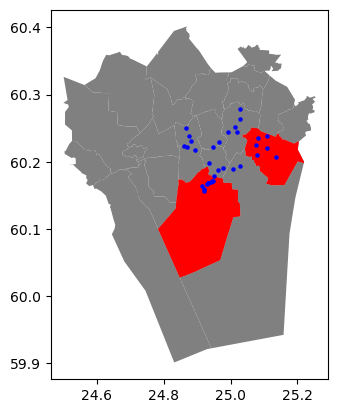

In [34]:
# Plot each layer on top of each other, starting with the base

# Base layer
base = districts.plot(facecolor="gray")

# Selection, red area
selection.plot(ax=base, facecolor="red")

# Points, blue dots
points.plot(ax=base, color="blue", markersize=5)

We can see in the figure that many points seem to be within the two selected districts. We can create a query to find out which ones are located within the polygon. We can do this by checking which Points in the points GeoDataFrame are within the selected polygons stored in the selection geodataframe. This can be done with the **.sjoin()** method to select all points that are within the selected polygons.

We can use **selection.geometry.to_frame()** when calling the **.sjoin()** method to avoid attaching any extra attributes from the selection geodataframe to our data, which is what **.sjoin()** method would normally do: 

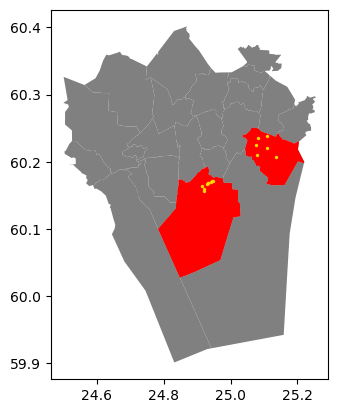

In [35]:
# Select ther points within the selected polygons
selected_points = points.sjoin(selection.geometry.to_frame(), predicate="within")

# Plot by layers
ax = districts.plot(facecolor="gray")
ax = selection.plot(ax=ax, facecolor="red")
ax = selected_points.plot(ax=ax, color="gold", markersize=2)

We have now selected only the points that are inside the red polygons. 

In a similar manner, we can easily use the **.sjoin()** with other predicates to make selections based on how the geometries between two GeoDataFrames are related to each other. By default, **.sjoin()** uses "intersects" as a spatial predicate, but it is easy to change this. For example, we can investigate which of the districts contain at least one point. In this case, we make a spatial join using the disctricts GeoDataFrame as a starting point, join the layer with the points and use the "contains" as a value to our predicate parameter:

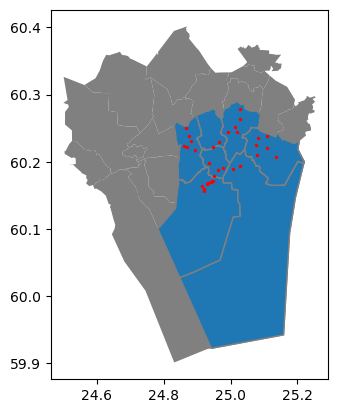

In [36]:
# Define which districtrs contain at least one point
districts_with_points = districts.sjoin(
    points.geometry.to_frame(), predicate="contains"
)

# Plot
ax = districts.plot(facecolor="gray")
ax = districts_with_points.plot(ax=ax, edgecolor="gray")
ax = points.plot(ax=ax, color="red", markersize=2)

It is important to remember that whenever making spatial queries, both layers need to share the same Coordinate Reference System for the selection to work properly. 

Thank you for reading!